# Demonstration Script to Generate Stereo Data

Workflow:
1. Get all shapenet ids from 'data/objects'
2. Load occupany values from 'data/occupancy'
3. For each mesh
    - Render left image
    - right image
    - Return pose
4. Save images, poses, and occupancy to 'data/stereo_training_data'

In [1]:
import os
import os.path as osp

import numpy as np
import trimesh 
import pyrender
import doctest
import pickle
import os.path as osp
from scipy.spatial.transform import Rotation as R

from typing import List
import tqdm

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

## Get paths to everything

In [2]:
# -- Load Objects -- #
data_dir = '../data/'
objects_to_dir = {
    'mug': 'mug_centered_obj',
    'bowl': 'bowl_centered_obj',
    'bottle': 'bottle_centered_obj'
}
mug_data_path = osp.join(data_dir, 'objects', objects_to_dir['mug']) 
bowl_data_path = osp.join(data_dir, 'objects', objects_to_dir['bottle']) 
bottle_data_path = osp.join(data_dir, 'objects', objects_to_dir['bottle']) 

mug_shapenet_ids = os.listdir(mug_data_path)
bowl_shapenet_ids = os.listdir(bowl_data_path)
bottle_shapenet_ids = os.listdir(bottle_data_path)

# -- Load Occupancy -- #
mug_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_mug.p')
bowl_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_bowl.p')
bottle_occ_path = osp.join(data_dir, 'occupancy', 'occ_shapenet_bottle.p')

# -- Save dir -- #
mug_stereo_path = osp.join(data_dir, 'stereo_training_data', 'mug')
bowl_stereo_path = osp.join(data_dir, 'stereo_training_data', 'bowl')
bottle_stereo_path = osp.join(data_dir, 'stereo_training_data', 'bottle')

In [3]:
print(mug_shapenet_ids)
print(bowl_shapenet_ids)
print(bottle_shapenet_ids)

print(mug_data_path)
print(bowl_data_path)
print(bottle_data_path)

['ca198dc3f7dc0cacec6338171298c66b', '8f550770386a6cf82f23d8349a133d2b', '2d10421716b16580e45ef4135c266a12', '5c7c4cb503a757147dbda56eabff0c47', '8b1dca1414ba88cb91986c63a4d7a99a', 'b4ae56d6638d5338de671f28c83d2dcb', '3d1754b7cb46c0ce5c8081810641ef6', '962883677a586bd84a60c1a189046dd1', 'c0c130c04edabc657c2b66248f91b3d8', 'b88bcf33f25c6cb15b4f129f868dedb', 'a8f7a0edd3edc3299e54b4084dc33544', 'dcec634f18e12427c2c72e575af174cd', '6dd59cc1130a426571215a0b56898e5e', '71995893d717598c9de7b195ccfa970', 'daee5cf285b8d210eeb8d422649e5f2b', 'e6dedae946ff5265a95fb60c110b25aa', 'b18bf84bcd457ffbc2868ebdda32b945', '128ecbc10df5b05d96eaf1340564a4de', 'a637500654ca8d16c97cfc3e8a6b1d16', 'e9499e4a9f632725d6e865157050a80e', '6faf1f04bde838e477f883dde7397db2', '5d72df6bc7e93e6dd0cd466c08863ebd', '44f9c4e1ea3532b8d7b20fded0142d7a', '9d8c711750a73b06ad1d789f3b2120d0', '2852b888abae54b0e3523e99fd841f4', 'cf777e14ca2c7a19b4aad3cc5ce7ee8', 'e9bd4ee553eb35c1d5ccc40b510e4bd', '92d6394732e6058d4bcbafcc905a9b98

## Define render helpers

In [4]:
def make_rotation_matrix(axis: str, theta: float):
    """
    Make rotation matrix about {axis} with angle {theta}

    Args:
        axis (str): {'x', 'y', 'z'}
        theta (float): angle in radians
    """

    s = np.sin(theta)
    c = np.cos(theta)

    if axis == 'x':
        r = [[1, 0, 0],
             [0, c, -s],
             [0, s, c]]

    elif axis == 'y':
        r = [[c, 0, s],
             [0, 1, 0],
             [-s, 0, c]]

    elif axis == 'z':
        r = [[c, -s, 0],
             [s, c, 0],
             [0, 0, 1]]

    else:
        raise ValueError('Unexpected axis')

    return r

In [5]:
def make_camera_pose(r, theta):
    """
    Make homologous camera pose matrix using r and theta according to 
    diagram above.

    Args:
        r (float): Radius of cameras from scene orgin, unit is meters.
        theta (float): Angle of camera from z axis, unit is radians.
    >>> np.array_equal(make_camera_pose(1, 0), \
    np.array([[ 1.,  0.,  0.,  0.], \
              [ 0.,  1.,  0.,  0.], \
              [ 0.,  0.,  1.,  1.], \
              [ 0.,  0.,  0.,  1.]]))

    True
    """
    l_z = r * np.cos(theta)
    l_x = r * np.sin(theta)
    rotation = make_rotation_matrix('y', theta)

    pose_mat = np.eye(4)
    pose_mat[:3, :3] = rotation
    pose_mat[:3, 3] = np.array([l_x, 0, l_z])

    return pose_mat


In [6]:
def render_mesh(mesh_fname, n_samples=1000, cam_r=1, cam_theta=np.pi/16):
    """
    Render mesh in random poses.

    Note: If getting a display error, try 
    `os.environ['PYOPENGL_PLATFORM'] = 'egl'`

    Args:
        mesh_fname (string): path to mesh file
        n_samples (int, optional): Number of random poses to sample. Defaults to 1000.

    Returns:
        Tuple(np.array, np.array, np.array): Left image, right image, object pose
    """
    # -- Load mesh -- #
    mesh = trimesh.load(mesh_fname)
    scene = pyrender.Scene()
    renderer = pyrender.OffscreenRenderer(224, 224)
    baseColorFactor = [210, 210, 210, 1]
    texture = pyrender.MetallicRoughnessMaterial('mug_material', baseColorFactor=baseColorFactor) 
    mesh_node = scene.add(pyrender.Mesh.from_trimesh(mesh, material=texture))

 
    # -- Define Cameras -- #
    l_cam_pose = make_camera_pose(cam_r, -cam_theta)
    r_cam_pose = make_camera_pose(cam_r, cam_theta)

    camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
    l_cam_node = scene.add(camera, pose=l_cam_pose)
    r_cam_node = scene.add(camera, pose=r_cam_pose)

    # -- Define Lights -- #
    light = pyrender.SpotLight(color=np.ones(3), 
                               intensity=3.0, 
                               innerConeAngle=np.pi/16.0, 
                               outerConeAngle=np.pi/6.0)
    scene.add(light, pose=l_cam_pose)
    scene.add(light, pose=r_cam_pose)

    # -- Render -- #
    color_l_images = []
    color_r_images = []
    object_poses = []
    for i in range(n_samples):
        random_pose = np.eye(4)
        random_pose[:3, :3] = R.random().as_matrix()
        scene.set_pose(mesh_node, pose=random_pose)

        scene.main_camera_node = l_cam_node
        color_l, depth_l = renderer.render(scene)
        scene.main_camera_node = r_cam_node
        color_r, depth_r = renderer.render(scene)

        color_l_images.append(color_l)
        color_r_images.append(color_r)
        object_poses.append(random_pose)
    
    renderer.delete()
    return color_l_images, color_r_images, object_poses

In [7]:
def render_batch(data_path: str, shapenet_ids: List[str], save_dir: str, n_samples_per_ob=1000):
    os.makedirs(save_dir, exist_ok=True)
    
    # images are 224 x 224 x 3
    shapenet_ids_wrapped = tqdm.tqdm(shapenet_ids)
    for shapenet_id in shapenet_ids_wrapped:
        mesh_fname = osp.join(data_path, shapenet_id, 'models/model_128_df.obj')
        try:
            l_images, r_images, poses = render_mesh(mesh_fname, n_samples=n_samples_per_ob)
        except ValueError:
            print('Error rendering mesh: ', shapenet_id)
            continue

        id_save_dir = osp.join(save_dir, shapenet_id)
        os.makedirs(id_save_dir, exist_ok=True)
        for i, data in enumerate(zip(l_images, r_images, poses)):
            l_image, r_image, pose = data
            
            save_fname = osp.join(id_save_dir, 'pose_' + str(i))
            # You must load the occupany with the dataloader
            np.savez(save_fname,
                l_image = l_image,
                r_image = r_image,
                pose = pose,
                shapenet_id = shapenet_id,
            )

In [ ]:
render_batch(mug_data_path, mug_shapenet_ids, mug_stereo_path, n_samples_per_ob=10)

In [8]:
def plot_image_lists(l_images, r_images):
    """
    Plot list of images side by side.

    Args:
        l_images (list): List of left images
        r_images (list): List of right images
    """
    import matplotlib.pyplot as plt
    im_dim = 2
    fig, axs = plt.subplots(len(l_images), 2, figsize=(2 * im_dim, len(l_images) * im_dim))
    for i in range(len(l_images)):
        axs[i, 0].imshow(l_images[i])
        axs[i, 1].imshow(r_images[i])
    plt.show()

[[ 0.24556475 -0.74846669  0.61603211  0.        ]
 [ 0.63131087  0.60572853  0.48429282  0.        ]
 [-0.73562527  0.26998253  0.62126073  0.        ]
 [ 0.          0.          0.          1.        ]]
ca198dc3f7dc0cacec6338171298c66b
[[-0.61768403  0.76946906  0.16243091  0.        ]
 [-0.7686265  -0.54699093 -0.33168392  0.        ]
 [-0.16637228 -0.32972457  0.92930187  0.        ]
 [ 0.          0.          0.          1.        ]]
ca198dc3f7dc0cacec6338171298c66b
[[-0.17966869 -0.89818162  0.40123427  0.        ]
 [ 0.88691597 -0.32434455 -0.32890831  0.        ]
 [ 0.42555754  0.29676656  0.85488618  0.        ]
 [ 0.          0.          0.          1.        ]]
ca198dc3f7dc0cacec6338171298c66b
[[ 0.26005511 -0.87373758 -0.41104012  0.        ]
 [ 0.92926367  0.34213157 -0.13933784  0.        ]
 [ 0.2623745  -0.34572913  0.90090565  0.        ]
 [ 0.          0.          0.          1.        ]]
ca198dc3f7dc0cacec6338171298c66b
[[ 0.8618575   0.3669107  -0.35011167  0.       

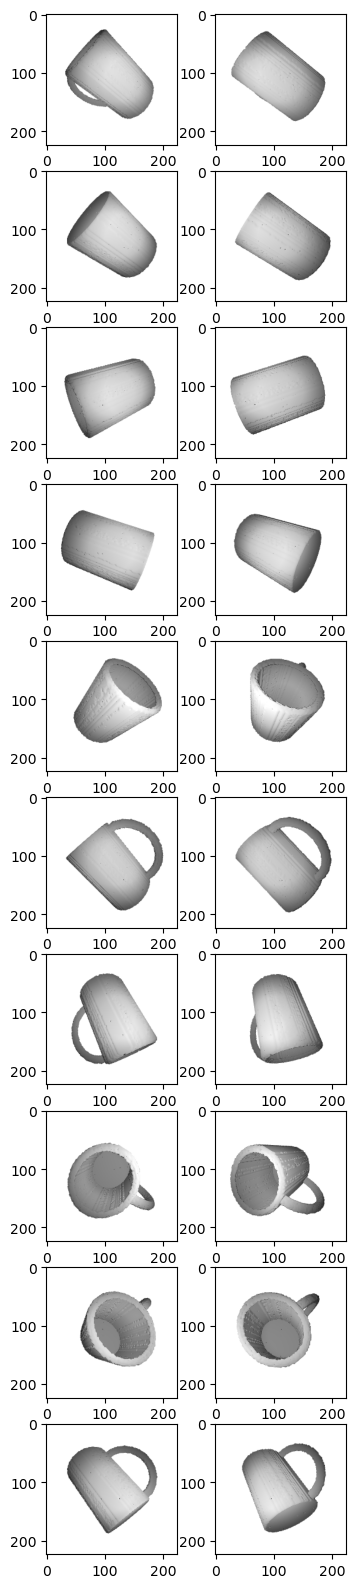

In [9]:
l_image_list = []
r_image_list = []

for i in range(10):
    test_data = np.load(osp.join(mug_stereo_path, 'ca198dc3f7dc0cacec6338171298c66b', f'pose_{i}.npz'), allow_pickle=True)
    l_image_list.append(test_data['l_image'])
    r_image_list.append(test_data['r_image'])
    print(test_data['pose'])
    print(test_data['shapenet_id'])
plot_image_lists(l_image_list, r_image_list)